In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import hyperspy.api as hs
from numba import njit
from numba import jit
from numba import prange
import time

In [2]:
def icp(src,dest, Tr, no_iterations = 13):    

    #Initialise with the initial pose estimation
    
    src = cv2.transform(src, Tr[0:2])

    for i in range(no_iterations):
        #Find the nearest neighbours between the current source and the
        #destination cloudpoint
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(dst[0])
        distances, indices = nbrs.kneighbors(src[0])

        #Compute the transformation between the current source
        #and destination cloudpoint
        T,inliners = cv2.estimateAffinePartial2D(src, dst[0, indices.T],confidence= 0.99,ransacReprojThreshold=3,refineIters=10000)
        #Transform the previous source and update the
        #current source cloudpoint
        src = cv2.transform(src, T)
        #Save the transformation from the actual source cloudpoint
        #to the destination
        Tr = np.dot(Tr, np.vstack((T,[0,0,1])))
    return Tr[0:2]

In [3]:
#Create the datasets
ang = np.linspace(-np.pi/2, np.pi/2, 320)
a = np.array([ang, np.sin(ang)])
th = np.pi/2
rot = np.array([[np.cos(th), -np.sin(th)],[np.sin(th), np.cos(th)]])
b = np.dot(rot, a) + np.array([[0.2], [0.3]])

#Run the icp
M2 = icp(src,dest,np.array([[0.14231484,-0.98982144,0.1],[0.98982144,0.14231484,0.33]]), 100)

#Plot the result
src = np.array([a.T]).astype(np.float32)
res = cv2.transform(src, M2)
plt.figure()
plt.plot(b[0],b[1])
plt.plot(res[0].T[0], res[0].T[1], 'r.')
plt.plot(a[0], a[1])
plt.show()

NameError: name 'src' is not defined

In [5]:
img0 = np.load(r"C:\Users\tas72\Documents\PhD\dg606\20230624\Stitching_and_corr\test\20230624_101320_vbf.npy")[:,:]

In [6]:
img1 = np.load(r"C:\Users\tas72\Documents\PhD\dg606\20230624\Stitching_and_corr\test\20230624_100824_vbf.npy")[:,:]

In [30]:
s0 = hs.signals.Signal2D(img0).as_lazy(True)

In [31]:
s1 = hs.signals.Signal2D(img1).as_lazy(True)

In [7]:
def xyz_from_arr(arr):
    xyz = np.zeros((np.shape(arr)[0]*np.shape(arr)[1], 3))
    for i in range(np.shape(arr)[0]):
        for j in range(np.shape(arr)[1]):
            xyz[i*np.shape(arr)[0]+j] = i,j,arr[i,j]
    return xyz

In [8]:
xyz0 = xyz_from_arr(img0)
xyz1 = xyz_from_arr(img1) 

In [35]:
xyz0 = s0.map(xyz_from_arr, parallel=True,inplace=False, lazy_output=True)
xyz1 = s1.map(xyz_from_arr, parallel=True,inplace=False, lazy_output=True)

In [36]:
xyz0.rechunk(nav_chunks='auto', sig_chunks=1000, inplace=True)
xyz1.rechunk(nav_chunks='auto', sig_chunks=1000, inplace=True)

In [6]:
len(xyz0.data)

262144

In [9]:
@jit(nopython=True,parallel=True)
def nearest_neighbor(src, dst):
    # dist = np.linalg.norm(src[:, None] - dst, axis=-1)
    indicies = np.zeros(len(src))
    for i in prange(len(src)):
        src_point = src[i]
        distances = np.sqrt(((src_point[0]-dst[:,0])**2)+((src_point[1]-dst[:,1]))**2+((src_point[2]-dst[:,2])**2))
        indicies[i] = np.argmin(distances)
    return indicies
#dist, ind = nearest_neighbor(xyz0, xyz1)

In [13]:
t0 = time.time()
indicies= nearest_neighbor(xyz0,xyz1)
t1 = time.time()

In [15]:
indicies

array([  4619.,   5134.,   1025., ..., 258470., 259495., 260519.])

In [22]:
sum_change_x = 0
sum_change_y = 0
for i,point in enumerate(indicies):
    change = xyz0[i]-xyz1[int(point)]
    sum_change_x += change[0]
    sum_change_y += change[1]

In [24]:
sum_change_x/len(indicies)

1.3495903015136719

In [25]:
sum_change_y/len(indicies)

-0.1382293701171875

In [81]:
X = np.array([[0, 2,3], [1, 2,5], [1, 2,1], [1,0, 1], [2,2, 1], [2,1, 2]])
nbrs = NearestNeighbors(n_neighbors=2, algorithm='brute',metric='euclidean').fit(X)
distances, indices = nbrs.kneighbors(X)

In [82]:
img = np.zeros((3,3))
for point in X:
    print(point)
    img[point[0],point[1]] = point[2]

[0 2 3]
[1 2 5]
[1 2 1]
[1 0 1]
[2 2 1]
[2 1 2]


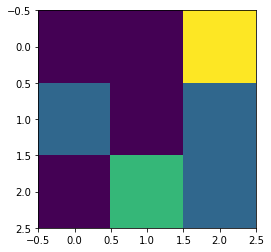

In [51]:
fig,ax = plt.subplots()
ax.imshow(img)

In [32]:
p0, p1 = 0,1
np.sqrt((X[p0][0]-X[p1][0])**2+(X[p0][1]-X[p1][1])**2+(X[p0][2]-X[p1][2])**2)

3.1622776601683795

In [47]:
indices

array([[0, 1],
       [1, 0],
       [2, 4],
       [3, 5],
       [4, 2],
       [5, 4]], dtype=int64)

In [48]:
sum_x_displacement = 0
sum_y_displacement = 0
for point_pair in indices:
    p0 = X[point_pair[0]]
    p1 = X[point_pair[1]]
    x_displacement = p1[0]-p0[0]
    y_displacement = p1[1]-p0[1]
    sum_x_displacement += x_displacement
    sum_y_displacement += y_displacement

[0 1]
[0 2 3] [1 2 5]
[1 0]
[1 2 5] [0 2 3]
[2 4]
[1 2 1] [2 2 1]
[3 5]
[1 0 1] [2 1 2]
[4 2]
[2 2 1] [1 2 1]
[5 4]
[2 1 2] [2 2 1]
